In [1]:
# !pip install kaggle
# !kaggle datasets download -p dataset/ --unzip cpanag/aifloodsense

In [2]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
import random
from torch import nn
from tqdm import tqdm
from torchmetrics import JaccardIndex

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
classes_info = pd.DataFrame({
    'class': ['background', 'flood', 'sky', 'building'],
    'grayscale_value': [0, 255, 170, 85],
    'class_index': [0, 1, 2, 3]
})

classes_info

,class,grayscale_value,class_index
0,background,0,0
1,flood,255,1
2,sky,170,2
3,building,85,3


In [5]:
TRAIN_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'images')
TRAIN_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'train', 'masks')
VAL_IMAGES_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'images')
VAL_MASKS_PATH = os.path.join('dataset', 'AIFloodSense', 'AIFloodSense', 'test', 'masks')

In [6]:
for image_name in os.listdir(TRAIN_IMAGES_PATH):
    image_path = os.path.join(TRAIN_IMAGES_PATH, image_name)
    mask_name = image_name.split('.')[0] + '.png'
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_name)

image_path, mask_path

('dataset/AIFloodSense/AIFloodSense/train/images/157.jpg',
 'dataset/AIFloodSense/AIFloodSense/train/masks/157.png')

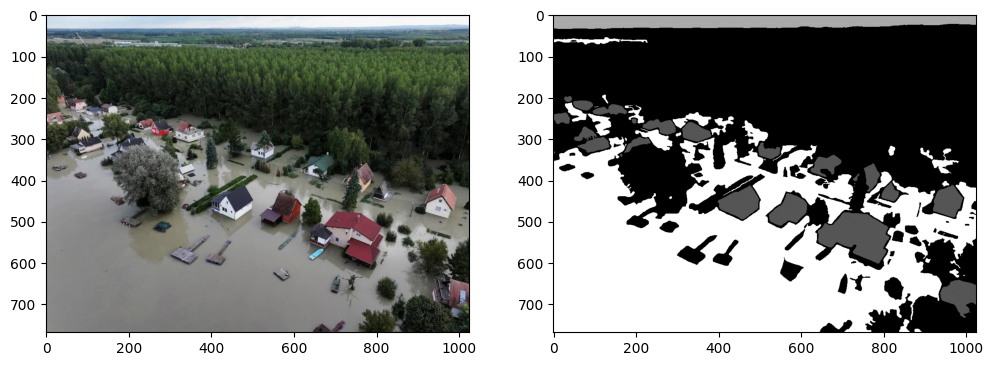

In [7]:
image = Image.open(image_path)
mask = Image.open(mask_path)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

In [8]:
mask_np = np.array(mask)
np.unique(mask_np)

array([  0,  85, 170, 255], dtype=uint8)

In [9]:
def color_to_index(mask):
    mask_indexes = []

    for color in classes_info['grayscale_value'].values:
        mask_indexes.append(torch.where(mask == color, 1, 0).tolist())

    return torch.tensor(mask_indexes).argmax(dim=0)

In [10]:
color_to_index(torch.tensor(mask_np)).unique()

tensor([0, 1, 2, 3])

In [11]:
IMAGE_SIZE = 256

transforms = {
    'image': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        v2.ToDtype(torch.float, scale=True)
    ]),
    'mask': v2.Compose([
        v2.ToImage(),
        v2.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=InterpolationMode.NEAREST_EXACT),
        v2.ToDtype(torch.long, scale=False)
    ])
}

In [12]:
class FloodsDataset(Dataset):
    def __init__(self, images_path, masks_path, transforms):
        super().__init__()
        self.images_pathes = []
        self.masks_pathes = []
        self.transforms = transforms

        for image_name in os.listdir(images_path):
            image_path = os.path.join(images_path, image_name)
            mask_name = image_name.split('.')[0] + '.png'
            mask_path = os.path.join(masks_path, mask_name)
            self.images_pathes.append(image_path)
            self.masks_pathes.append(mask_path)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index):
        image_path = self.images_pathes[index]
        mask_path = self.masks_pathes[index]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        transformed_image = self.transforms['image'](image)
        transformed_mask = self.transforms['mask'](mask)
        indexed_mask = color_to_index(transformed_mask.squeeze())
        return transformed_image, indexed_mask

In [13]:
train_ds = FloodsDataset(TRAIN_IMAGES_PATH, TRAIN_MASKS_PATH, transforms)
val_ds = FloodsDataset(VAL_IMAGES_PATH, VAL_MASKS_PATH, transforms)
len(train_ds), len(val_ds)

(376, 94)

tensor([0, 1, 2, 3])


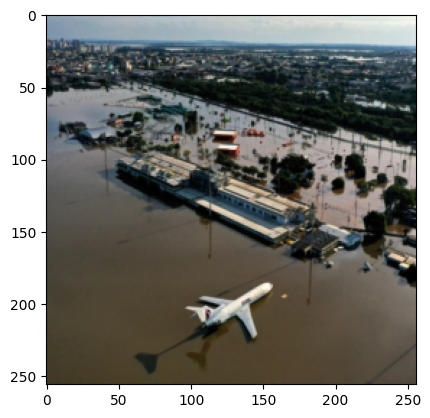

In [14]:
random_index = random.randint(0, len(train_ds) - 1)
random_image = train_ds[random_index][0]
random_mask = train_ds[random_index][1]
print(random_mask.unique())
plt.imshow(random_image.permute(1, 2, 0))


In [15]:
BATCH_SIZE = 16

train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [16]:
for batch in train_loader:
    images = batch[0]
    image_sample = images[0]
    masks = batch[1]
    mask_sample = masks[0]
    break

tensor([0, 1, 3])


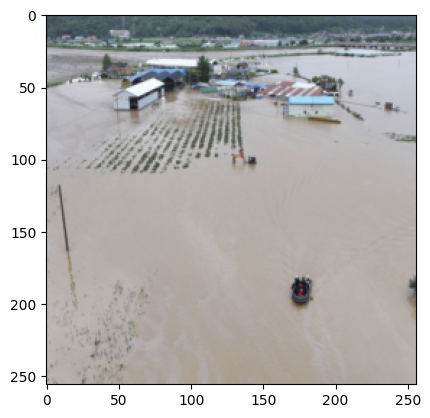

In [17]:
print(mask_sample.unique())
plt.imshow(image_sample.permute(1, 2, 0))

In [18]:
mask_sample.shape

torch.Size([256, 256])

In [19]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [20]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, first_block=False):
        super().__init__()
        if first_block:
            out_channels = 64
        else:
            out_channels = in_channels * 2

        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, batch):
        conv1 = self.conv1(batch)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_norm = self.norm(conv2)
        conv2_act = self.act(conv2_norm)
        return conv2_act

In [21]:
class DecoderBlock(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        in_channels = encoder_channels + decoder_channels
        out_channels = decoder_channels // 2

        self.upconv = nn.ConvTranspose2d(decoder_channels, decoder_channels, 2, 2)
        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, decoder_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(decoder_channels, out_channels, 3, padding='same')
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding='same')

    def forward(self, encoder, decoder):
        upconved = self.upconv(decoder)
        concatenated = torch.concat([encoder, upconved], dim=1)
        conv1 = self.conv1(concatenated)
        conv1_act = self.act(conv1)
        conv2 = self.conv2(conv1_act)
        conv2_act = self.act(conv2)
        conv3 = self.conv3(conv2_act)
        conv3_norm = self.norm(conv3)
        conv3_act = self.act(conv3_norm)
        return conv3_act

In [22]:
class CustomUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2)
        self.encoder1 = EncoderBlock(3, True)
        self.encoder2 = EncoderBlock(64)
        self.encoder3 = EncoderBlock(128)
        self.encoder4 = EncoderBlock(256)
        self.encoder5 = EncoderBlock(512)
        self.decoder1 = DecoderBlock(512, 1024)
        self.decoder2 = DecoderBlock(256, 512)
        self.decoder3 = DecoderBlock(128, 256)
        self.decoder4 = DecoderBlock(64, 128)
        self.last_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, batch):
        encoder1 = self.encoder1(batch)
        encoder1_pool = self.pooling(encoder1)
        encoder2 = self.encoder2(encoder1_pool)
        encoder2_pool = self.pooling(encoder2)
        encoder3 = self.encoder3(encoder2_pool)
        encoder3_pool = self.pooling(encoder3)
        encoder4 = self.encoder4(encoder3_pool)
        encoder4_pool = self.pooling(encoder4)
        encoder5 = self.encoder5(encoder4_pool)
        decoder1 = self.decoder1(encoder4, encoder5)
        decoder2 = self.decoder2(encoder3, decoder1)
        decoder3 = self.decoder3(encoder2, decoder2)
        decoder4 = self.decoder4(encoder1, decoder3)
        output = self.last_conv(decoder4)
        return output

In [23]:
model = CustomUNet(len(classes_info))
model(batch[0]).shape

torch.Size([16, 4, 256, 256])

In [24]:
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (e

In [25]:
classes_nums = torch.zeros((len(classes_info), ))

for sample in train_ds:
    mask = sample[1]
    for i in range(len(classes_info)):
        classes_nums[i] += torch.where(mask == i, 1, 0).sum()

epsilon = 1e-6
classes_weights = (1 + epsilon) / (classes_nums + epsilon)
classes_weights /= classes_weights.mean()
classes_weights = classes_weights.to(device)
classes_weights

tensor([0.3549, 0.2727, 2.0021, 1.3703], device='cuda:0')

In [26]:
loss_fn = nn.CrossEntropyLoss(weight=classes_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
jaccard_index = JaccardIndex('multiclass', num_classes=len(classes_info)).to(device)

In [27]:
def train(model, loader, loss_fn, optimizer):
    iou_sum = 0
    loss_sum = 0

    model.train()
    for X, Y in tqdm(loader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, Y)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1)
        iou_sum += jaccard_index(pred, Y).item()
        loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [28]:
def evaluate(model, loader, loss_fn):
    iou_sum = 0
    loss_sum = 0

    model.eval()
    with torch.no_grad():
        for X, Y in tqdm(loader):
            X, Y = X.to(device), Y.to(device)
            output = model(X)
            loss = loss_fn(output, Y)
            pred = output.argmax(dim=1)
            iou_sum += jaccard_index(pred, Y).item()
            loss_sum += loss.item()

    return iou_sum / len(loader), loss_sum / len(loader)

In [29]:
EPOCHS = 30
train_losses = []
train_metrics = []
val_losses = []
val_metrics = []
min_val_loss = None

for epoch in range(1, EPOCHS + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_iou, train_loss = train(model, train_loader, loss_fn, optimizer)
    train_metrics.append(train_iou)
    train_losses.append(train_loss)
    print(f'Train IoU: {train_iou}')
    print(f'Train loss: {train_loss}')
    val_iou, val_loss = evaluate(model, val_loader, loss_fn)
    val_metrics.append(val_iou)
    val_losses.append(val_loss)
    print(f'Val IoU: {val_iou}')
    print(f'Val loss: {val_loss}')
    lr_scheduler.step(val_loss)

    if not min_val_loss or min_val_loss > val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'models/best_params.pt')
        print('Best model saved')

----------
Epoch 1:


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Train IoU: 0.43890497212608653
Train loss: 0.88759545981884


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Val IoU: 0.1040487289428711
Val loss: 1.4044865171114604
Best model saved
----------
Epoch 2:


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Train IoU: 0.5373230030139288
Train loss: 0.6492155492305756


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Val IoU: 0.14337965721885362
Val loss: 1.8851259152094524
----------
Epoch 3:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.56362517674764
Train loss: 0.5950688906013966


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.4023342877626419
Val loss: 0.8124022384484609
Best model saved
----------
Epoch 4:


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Train IoU: 0.5715115194519361
Train loss: 0.5653601835171381


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.5328099379936854
Val loss: 0.6454156736532847
Best model saved
----------
Epoch 5:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.594189760585626
Train loss: 0.5443915339807669


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Val IoU: 0.5404754281044006
Val loss: 0.6255580137173334
Best model saved
----------
Epoch 6:


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Train IoU: 0.615106888115406
Train loss: 0.5190033614635468


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Val IoU: 0.5055901159842809
Val loss: 0.6085363527139028
Best model saved
----------
Epoch 7:


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Train IoU: 0.6211767469843229
Train loss: 0.4876922704279423


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Val IoU: 0.5392197171847025
Val loss: 0.6361262003580729
----------
Epoch 8:


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Train IoU: 0.614006387690703
Train loss: 0.4999244883656502


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Val IoU: 0.4610748042662938
Val loss: 0.6873540679613749
----------
Epoch 9:


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Train IoU: 0.6221903661886851
Train loss: 0.4915298980971177


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.438763548930486
Val loss: 0.8558333416779836
----------
Epoch 10:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.6410835559169451
Train loss: 0.464844932158788


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Val IoU: 0.5540392895539602
Val loss: 0.5561378399531046
Best model saved
----------
Epoch 11:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.633277547856172
Train loss: 0.45459945624073345


100%|██████████| 6/6 [00:09<00:00,  1.50s/it]


Val IoU: 0.5891757905483246
Val loss: 0.5340361396471659
Best model saved
----------
Epoch 12:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.65425243973732
Train loss: 0.44107915088534355


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


Val IoU: 0.5768980383872986
Val loss: 0.5377180427312851
----------
Epoch 13:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.6531657526890436
Train loss: 0.43827951451142627


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Val IoU: 0.5944802562395731
Val loss: 0.5280211766560873
Best model saved
----------
Epoch 14:


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Train IoU: 0.6612918103734652
Train loss: 0.4270292855799198


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.5740417341391245
Val loss: 0.5367838193972906
----------
Epoch 15:


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Train IoU: 0.6597065776586533
Train loss: 0.4353671322266261


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.5722236136595408
Val loss: 0.5330730825662613
----------
Epoch 16:


100%|██████████| 24/24 [00:46<00:00,  1.93s/it]


Train IoU: 0.6634878516197205
Train loss: 0.42075686777631444


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Val IoU: 0.6056155463059744
Val loss: 0.5222180932760239
Best model saved
----------
Epoch 17:


100%|██████████| 24/24 [00:45<00:00,  1.90s/it]


Train IoU: 0.6726627623041471
Train loss: 0.411833285043637


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Val IoU: 0.6013286411762238
Val loss: 0.5168336679538091
Best model saved
----------
Epoch 18:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.668391689658165
Train loss: 0.4157583775619666


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.6006625692049662
Val loss: 0.5250736524661382
----------
Epoch 19:


100%|██████████| 24/24 [00:46<00:00,  1.96s/it]


Train IoU: 0.6752816364169121
Train loss: 0.40908058484395343


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Val IoU: 0.599564790725708
Val loss: 0.5183040002981821
----------
Epoch 20:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.6706317191322645
Train loss: 0.4135604190329711


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.6223954558372498
Val loss: 0.5080853998661041
Best model saved
----------
Epoch 21:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.678318756322066
Train loss: 0.40323983629544574


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]


Val IoU: 0.6282689571380615
Val loss: 0.5041106045246124
Best model saved
----------
Epoch 22:


100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


Train IoU: 0.6771728893121084
Train loss: 0.41142015034953755


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.5831840435663859
Val loss: 0.5168579965829849
----------
Epoch 23:


100%|██████████| 24/24 [00:47<00:00,  1.96s/it]


Train IoU: 0.6681275765101115
Train loss: 0.4219928892950217


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Val IoU: 0.6139874160289764
Val loss: 0.49552877247333527
Best model saved
----------
Epoch 24:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.6892908463875452
Train loss: 0.39485486845175427


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.5981299678484598
Val loss: 0.5089815706014633
----------
Epoch 25:


100%|██████████| 24/24 [00:47<00:00,  1.97s/it]


Train IoU: 0.6850392570098242
Train loss: 0.3952767228086789


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.613147368033727
Val loss: 0.5046796302000681
----------
Epoch 26:


100%|██████████| 24/24 [00:45<00:00,  1.91s/it]


Train IoU: 0.6952731087803841
Train loss: 0.38859786341587704


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Val IoU: 0.5825449526309967
Val loss: 0.5305572102467219
----------
Epoch 27:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.6929776519536972
Train loss: 0.3832267001271248


100%|██████████| 6/6 [00:08<00:00,  1.49s/it]


Val IoU: 0.6122856040795644
Val loss: 0.4980844308932622
----------
Epoch 28:


100%|██████████| 24/24 [00:46<00:00,  1.95s/it]


Train IoU: 0.6923101594050726
Train loss: 0.3856722128887971


100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Val IoU: 0.606652577718099
Val loss: 0.5046749661366144
----------
Epoch 29:


100%|██████████| 24/24 [00:46<00:00,  1.92s/it]


Train IoU: 0.6901717782020569
Train loss: 0.38564610853791237


100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


Val IoU: 0.6121735572814941
Val loss: 0.4954723318417867
Best model saved
----------
Epoch 30:


100%|██████████| 24/24 [00:45<00:00,  1.89s/it]


Train IoU: 0.6923372993866602
Train loss: 0.3855193679531415


100%|██████████| 6/6 [00:08<00:00,  1.48s/it]

Val IoU: 0.608924388885498
Val loss: 0.5041523228089014


In [30]:
lr_scheduler.get_last_lr()

[1.0000000000000002e-06]

Text(0.5, 1.0, "IoU's")

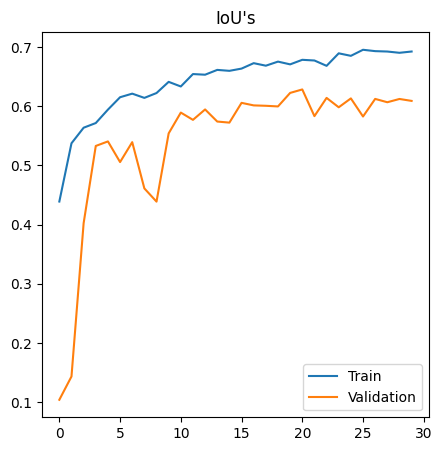

In [31]:
plt.figure(figsize=(5, 5))
plt.plot(train_metrics, label='Train')
plt.plot(val_metrics, label='Validation')
plt.legend()
plt.title('IoU\'s')

Text(0.5, 1.0, 'Losses')

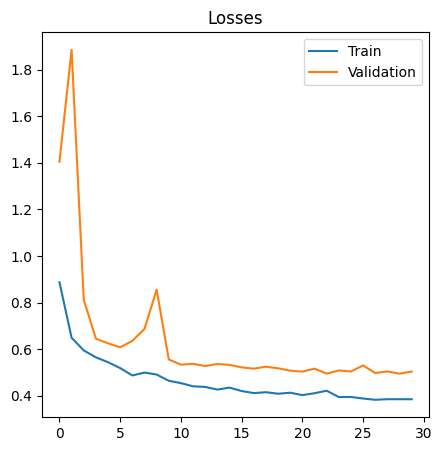

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.legend()
plt.title('Losses')

In [33]:
model = CustomUNet(len(classes_info))
model.load_state_dict(torch.load('models/best_params.pt', weights_only=True))
model.eval()
model.to(device)

CustomUNet(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder1): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder2): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (encoder3): EncoderBlock(
    (act): ReLU()
    (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (e

In [34]:
def index_to_color(mask):
    mask_colors = []

    for index in range(len(classes_info)):
        color = classes_info[classes_info['class_index'] == index]['grayscale_value'].item()
        mask_colors.append(torch.where(mask == index, color, 0).tolist())

    return torch.tensor(mask_colors).max(dim=0).values

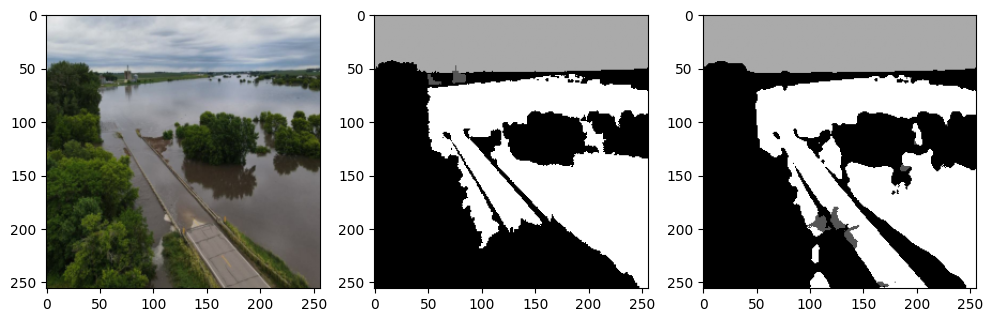

In [35]:
test_index = random.randint(0, len(train_ds) - 1)
test_image = train_ds[test_index][0]
test_mask = train_ds[test_index][1]
test_pred = model(test_image.unsqueeze(0).to(device))[0].argmax(dim=0)
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(test_image.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.imshow(index_to_color(test_mask), cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(index_to_color(test_pred), cmap='gray')